# 9. 경쟁하며 학습하는 GAN

## 9.0. 요약

### 9.0.1. 지난장

지난 장에서는 학습된 신경망에 대해 노이즈를 주어 신뢰성 있는 결과를 얻는 것을 방해하는 적대적 공격(Adversarial Attack)에 대해 알아보았다. 적대적 공격의 목표는 사람이 눈치채지 못하지만 ML 알고리즘에는 영향을 줄 수 있는 노이즈를 만드는 것이다. 그래서 예제로 FGSM을 활용한 적대적 공격을 살펴보았다.

### 9.0.2. 이번장

이번 장에서는 적대적 공격의 개념을 반영하여 신경망의 성능을 높이는 GAN(Generative Adversarial Network)에 대해서 알아보자. GAN은 비지도학습의 일종으로 앞으로 딥러닝의 발전을 이끌 신경망 중 하나로 꼽힌다. GAN은 생성부와 판별부로 나뉘며 생성부에서는 진짜 같은 가짜를 만드는 것을 목표로 하며, 판별부는 생성부의 결과값과 실제값을 올바르게 판별하는 것을 목표로 한다. 서로 다른 두 목표를 충족시켜 가며 학습을 수행하고 예측하는 신경망을 바로 GAN이라고 한다.

## 9.1. GAN의 기초

GAN(Generative Adversarial Network; 적대적 신경망)은 2014년 이안 굿펠로우(Ian Goodfellow)에 의해 제안된 신경망이다.

GAN에 의미에 대해 나누어서 살펴보면 아래와 같다.
1. Generative
: GAN은 생성을 하는 모델이다. 앞서 살펴본 CNN과 RNN처럼 결과를 임의의 결과값으로 매핑하는 것이 아니라 학습을 통해 input과 동일한 형태의 결과값을 생성하는 신경망이다
2. Adversarial
: GAN은 적대적으로 학습한다. GAN 방법론에서는 가짜 이미지를 생성하는 생성자(Generator)와 이미지의 진위를 판별하는 판별자(Discriminator)가 번갈아 학습하며 경쟁적으로 학습을 진행한다.
3. Network
: GAN은 인공 신경망 모델이다.

GAN이 많은 각광을 받고 있는 이유는 비지도학습 방법이기 때문이다. 이 떄문에 앞서 살펴본 오토인코더와 같이 사람의 손길을 최소화하며 학습을 진행한다.

### 9.1.1. 생성자와 판별자
![basic_structure](img/basic_structure.png)

기본적인 GAN의 모형은 9.1.절에서 설명한것과 같이 생성자와 판별자가 있으며, 각각의 손실을 이용하여 앞서 살펴본 신경망들과 동일하게 학습을 수행한다. 

* 생성자

생성자는 임의의 random vector를 생성하고, 이를 신경망을 거쳐 input 데이터와 비교 가능한 동일한 벡터로 출력한 후 둘 사이의 오차값을 계산하여 생성자를 학습시켜나간다.

* 판별자

변별자는 생성자를 통해 얻어낸 output과 실제 input 데이터를 판별하는 신경망이며, 이 둘을 판별하며 학습을 수행한다.

이렇게 생성자와 판별자간의 목표는 서로 상이하다. 생성자는 판별자를 속여야하고, 판별자는 생성자가 만들어낸 거짓 값을 판별할 줄 알아야 한다. 이 때문에 Adversarial하다고 말하며, 경쟁적인 관계를 통해 학습을 수행하는 것이다.

In [9]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm_notebook

In [3]:
# EPOCHS = 500
EPOCHS = 10
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = "cuda" if USE_CUDA else "cpu"
print("Available Device is {}".format(DEVICE))

Available Device is cpu


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = datasets.FashionMNIST(
    root = './data/',
    train = True,
#     download = True,
    download = False,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [5]:
Generator = nn.Sequential(
    nn.Linear(64,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Tanh()
)

Discriminator = nn.Sequential(
    nn.Linear(784, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    nn.Sigmoid()
)

In [6]:
D = Discriminator.to(DEVICE)
G = Generator.to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
for epoch in tqdm_notebook(range(EPOCHS)):
    for batch_num, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(BATCH_SIZE, -1).to(DEVICE)
        
        real_labels = torch.ones(BATCH_SIZE,1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE,1).to(DEVICE)
        
        # 판별자가 진짜와 가짜를 제대로 판별하는지에 대한 학습
        
        outputs = D(inputs)
        d_loss_real = criterion(outputs,real_labels)
        real_score = outputs
        
        z = torch.randn(BATCH_SIZE,64).to(DEVICE)
        fake_images = G(z)
        
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs,fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 제대로 속였는지에 대한 학습
        
        fake_images = G(z)
        output = D(fake_images)
        g_loss = criterion(output, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print("EPOCH [{}/{}]; d_loss: {}; g_loss: {}; D(x): {}; D(G(z)): {}".format(epoch+1, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

EPOCH [1/10]; d_loss: 0.1500527560710907; g_loss: 4.054120063781738; D(x): 0.9575328230857849; D(G(z)): 0.07295243442058563
EPOCH [2/10]; d_loss: 0.04560771584510803; g_loss: 5.376081943511963; D(x): 0.9880802631378174; D(G(z)): 0.01969369687139988
EPOCH [3/10]; d_loss: 0.01945931278169155; g_loss: 9.789103507995605; D(x): 0.9909818768501282; D(G(z)): 0.00887309666723013
EPOCH [4/10]; d_loss: 0.011903496459126472; g_loss: 6.646429061889648; D(x): 0.9953928589820862; D(G(z)): 0.006713151466101408
EPOCH [5/10]; d_loss: 0.01006362121552229; g_loss: 10.489091873168945; D(x): 0.997253954410553; D(G(z)): 0.0069230361841619015
EPOCH [6/10]; d_loss: 0.05904088914394379; g_loss: 5.994604587554932; D(x): 0.9857280254364014; D(G(z)): 0.0342160202562809
EPOCH [7/10]; d_loss: 0.06264542788267136; g_loss: 6.134653091430664; D(x): 0.9858736991882324; D(G(z)): 0.03231556713581085
EPOCH [8/10]; d_loss: 0.3016839623451233; g_loss: 4.738491058349609; D(x): 0.9360068440437317; D(G(z)): 0.06817293912172318

Text(0.5,0.94,'GAN Generated Images')

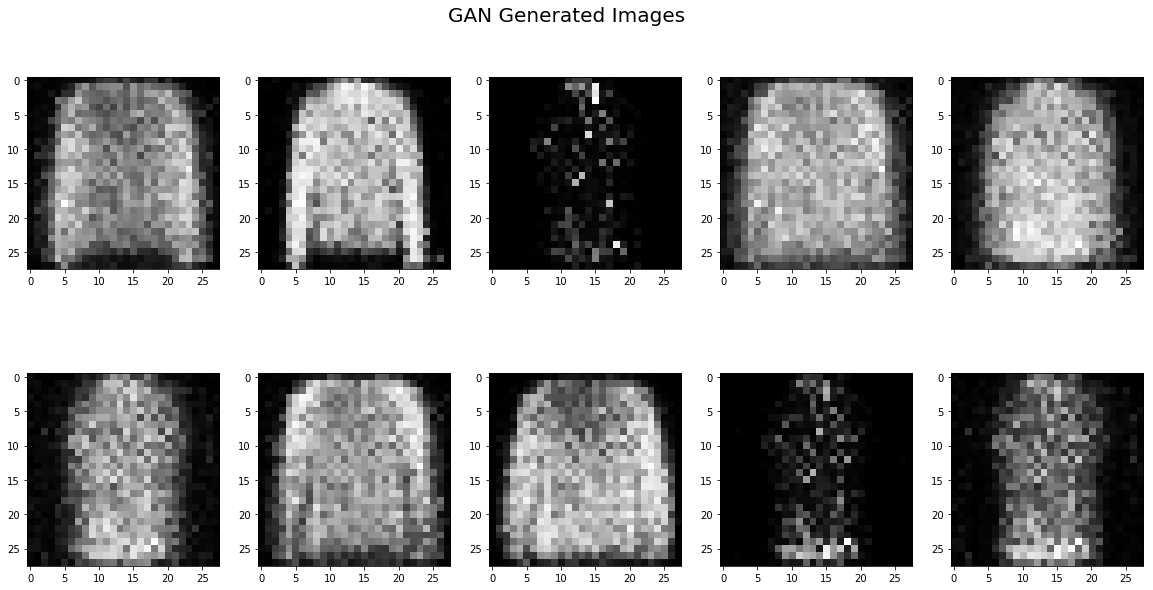

In [25]:
z = torch.randn(BATCH_SIZE,64).to(DEVICE)
fake_images = G(z)
fig, axes = plt.subplots(2,5,figsize=[20,10])
for i in range(10):
    row = i // 5
    col = i % 5
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28,28))
    axes[row][col].imshow(fake_images_img,cmap="gray")

plt.suptitle("GAN Generated Images",fontsize=20, y=0.94)

## 9.3. cGAN으로 생성 제어하기

앞서 살펴본 GAN에서 생성자는 임의의 랜덤 벡터를 생성하여 판별자에 진짜 라벨인 것처럼 하여 결과를 얻은 뒤 이로 얻은 오차를 통해 학습을 진행했다. 그런데, 이는 생성자가 범용적으로 판별자를 속이기 위해 임의의 기준 없이 생성하고 있다. 따라서 GAN이 좀 더 쓸모있으려면 원하는 이미지를 생성하는 기능을 만들어야 한다. 따라서 이런 Conditional 한 값을 제공하여 원하는 이미지를 생성하는 cGAN(Conditional GAN)에 대해서 살펴보자

![cGan with GAN](img/cGAN_w_GAN.png)

cGAN의 구성은 GAN과 비교했을 때, 그 데이터에 대한 Label값도 함께 학습에 사용되는지 여부이다. 판별자에서 임의의 값을 판별함에 있어서도 Label값이 사용되고 생성시에도 Random Vector와 Random Label이 사용됨으로써 특정 Label에 따라 그에 맞는 이미지가 결과적으로는 생성되고 판별되는 것이다.

In [71]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.embed = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
                                nn.Linear(110,256),
                                nn.LeakyReLU(0.2,inplace=True),
                                nn.Linear(256,512),
                                nn.LeakyReLU(0.2,inplace=True),
                                nn.Linear(512,1028),
                                nn.LeakyReLU(0.2,inplace=True),
                                nn.Linear(1028,784),
                                nn.Tanh()
                            )
        
    def forward(self, x, label):
        label = self.embed(label)
        x = torch.cat([x,label],1)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.embed = nn.Embedding(10,10)
        
        self.model = nn.Sequential(
                                nn.Linear(794,1028),
                                nn.LeakyReLU(0.2,inplace=True),
                                nn.Dropout(0.3),
                                nn.Linear(1028,512),
                                nn.LeakyReLU(0.2,inplace=True),
                                nn.Dropout(0.3),
                                nn.Linear(512,256),
                                nn.LeakyReLU(0.2,inplace=True),
                                nn.Dropout(0.3),
                                nn.Linear(256,1),
                                nn.Sigmoid()
                            )
        
    def forward(self, x, label):
        label = self.embed(label)
        x = torch.cat([x,label],1)
        return self.model(x)

In [72]:
d = Discriminator().to(DEVICE)
g = Generator().to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(d.parameters(), lr=0.0002)
g_optimizer = optim.Adam(g.parameters(), lr=0.0002)

In [75]:
for epoch in range(EPOCHS):
    for batch_num, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(BATCH_SIZE, -1).to(DEVICE)
        labels = labels.to(DEVICE)
        
        real_labels = torch.ones((BATCH_SIZE,1)).to(DEVICE)
        fake_labels = torch.zeros((BATCH_SIZE,1)).to(DEVICE)
        
        outputs = d(inputs,labels)
        d_loss_real = criterion(outputs,real_labels)
        real_score = outputs
        
        rand_img_vector = torch.randn((BATCH_SIZE,100)).to(DEVICE)
        random_labels = torch.randint(low=0,high=10, size=(BATCH_SIZE,)).to(DEVICE)
        fake_gen_images = g(rand_img_vector, random_labels)
        
        outputs = d(fake_gen_images,random_labels)
        d_loss_fake = criterion(outputs,fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        g.zero_grad()
        d.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        fake_gen_images = g(fake_images,random_labels)
        outputs = d(fake_gen_images, random_labels)
        g_loss = criterion(outputs,real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print("EPOCH [{}/{}]; d_loss: {}; g_loss: {}; D(x): {}; D(G(z)): {}".format(epoch+1, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

EPOCH [1/10]; d_loss: 0.19444051384925842; g_loss: 6.24436092376709; D(x): 0.9539788961410522; D(G(z)): 0.04378392547369003
EPOCH [2/10]; d_loss: 0.06105846166610718; g_loss: 6.6738433837890625; D(x): 0.9907469749450684; D(G(z)): 0.0366392657160759
EPOCH [3/10]; d_loss: 0.060632556676864624; g_loss: 10.621731758117676; D(x): 0.9944427609443665; D(G(z)): 0.020229918882250786
EPOCH [4/10]; d_loss: 0.043491411954164505; g_loss: 10.075153350830078; D(x): 0.9815113544464111; D(G(z)): 0.0071085854433476925
EPOCH [5/10]; d_loss: 0.008409993723034859; g_loss: 6.68901252746582; D(x): 0.9967542886734009; D(G(z)): 0.004352542106062174
EPOCH [6/10]; d_loss: 0.006521056406199932; g_loss: 9.969396591186523; D(x): 0.9966573119163513; D(G(z)): 0.002456778660416603
EPOCH [7/10]; d_loss: 7.827879744581878e-05; g_loss: 17.601612091064453; D(x): 0.9999392032623291; D(G(z)): 1.74207852978725e-05
EPOCH [8/10]; d_loss: 3.229426147299819e-05; g_loss: 12.879302978515625; D(x): 0.9999825954437256; D(G(z)): 1.48

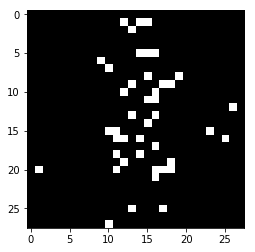

In [78]:
item_number = 9
z = torch.randn(1,100).to(DEVICE)
g_label = torch.full((1,),item_number,dtype=torch.long).to(DEVICE)
sample_images = g(z,g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28,28))
plt.imshow(sample_images_img, cmap="gray")
plt.show()